# CIFAR-100 이미지 생성

## Load library

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.8.2


## Data set

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 11s 0us/step


(50000, 32, 32, 3)

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [4]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


## check data

In [5]:
def de_normalize(train):
    return (127.5 * train) + 127.5

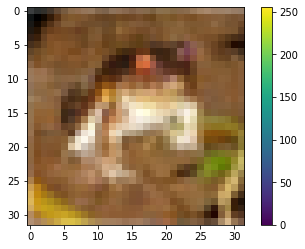

In [6]:
plt.imshow(de_normalize(train_x[0]).astype(np.int32).reshape(32, 32, 3))
plt.colorbar()
plt.show()

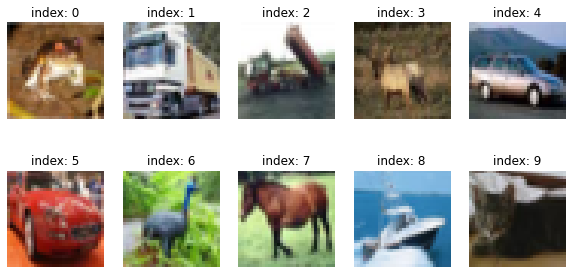

In [7]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(de_normalize(train_x[i]).astype(np.int32).reshape(32, 32, 3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

## Mini batch

In [8]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Generator

In [10]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [11]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

In [12]:
noise = tf.random.normal([1, 100])


generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

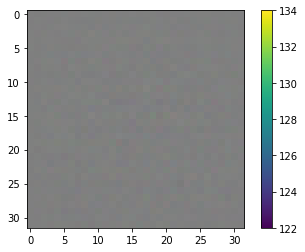

In [13]:
plt.imshow(de_normalize(generated_image[0].numpy()).astype(np.int32))
plt.colorbar()
plt.show()

## Discriminator

In [14]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [15]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

In [16]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00058242]], dtype=float32)>

## Loss function and Optimizer

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## Discriminator accuracy

In [19]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [20]:
## optimizer

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [21]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## Training

In [22]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [32]:
def generate_and_save_images(model, epoch, it, sample_seeds, save_file_num=1):

    predictions = model(sample_seeds, training=False)  # 16개의 seed 가 들어있는 sample_seeds
    
    # [-1,1]로 정규화된 이미지를 원상복구함
    rescue_predictions = (predictions.numpy() * 127.5 + 127.5).astype(int)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)  # 16개 sample 이라서 4행 4열로 시각화
        plt.imshow(rescue_predictions[i])  # plt.imshow(np.array(predictions[i, :, :, :]*127.5 + 127.5).astype('uint8'))
        plt.axis('off')
   
    plt.tight_layout()  # subplot 간격 자동 조절(겹치지 않게)

    save_file_path = 'drive/MyDrive/Colab Notebooks/dcgan_newimage/cifar10/generated_samples/sample_{}'.format(save_file_num)
    if not os.path.exists(save_file_path):
        os.makedirs(save_file_path)
    
    save_file_path = os.path.join(save_file_path, 'sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
    plt.savefig(save_file_path)  # 이미지 저장

    plt.show()

In [33]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch, save_file_num=1):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')

    plt.tight_layout()  # subplot 간격 자동 조절(겹치지 않게)
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    save_file_path = 'drive/MyDrive/Colab Notebooks/dcgan_newimage/cifar10/training_history/train_history_{}'.format(save_file_num)
    if not os.path.exists(save_file_path):
        os.makedirs(save_file_path)
    
    save_file_path = os.path.join(save_file_path, 'train_history_{:04d}.png'.format(epoch))
    plt.savefig(save_file_path)  # 이미지 저장

    plt.show()


In [34]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Model trainging

In [35]:
def train(dataset, epochs, save_every, save_file_num=1):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed, save_file_num)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint_dir = 'drive/MyDrive/Colab Notebooks/dcgan_newimage/cifar10/training_checkpoints/training_checkpoints_{}'.format(save_file_num)
            checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed, save_file_num)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch, save_file_num)

In [36]:
save_every = 5  # 모델 저장 간격
EPOCHS = 150  # 학습 횟수

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[]

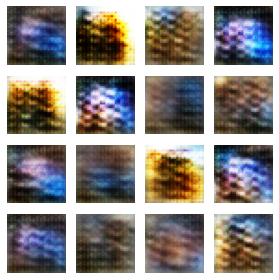

Epoch 16 | iter 101
Time for epoch 16 : 444 sec


KeyboardInterrupt: ignored

In [37]:
%%time
train(train_dataset, EPOCHS, save_every, 1)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 dcgan_newimage/cifar10/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [38]:
def make_a_gif(anim_file_num=1, flag=True):
    if flag:
        anim_file = 'drive/MyDrive/Colab Notebooks/dcgan_newimage/cifar10/gif/cifar10_dcgan_{}.gif'.format(anim_file_num)
        filenames = glob.glob('drive/MyDrive/Colab Notebooks/dcgan_newimage/cifar10/generated_samples/sample_{}/sample*.png'.format(anim_file_num))  # Fake Images
    else:
        anim_file = 'drive/MyDrive/Colab Notebooks/dcgan_newimage/cifar10/gif/cifar10_dcgan_history_{}.gif'.format(anim_file_num)
        filenames = glob.glob('drive/MyDrive/Colab Notebooks/dcgan_newimage/cifar10/training_history/train_history_{}/train_history*.png'.format(anim_file_num))  # Graphs

    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = sorted(filenames)
        last = -1
        for i, filename in enumerate(filenames):
            frame = 2*(i**0.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

In [39]:
# Fake Images to GIF
make_a_gif(1, True)

FileNotFoundError: ignored

In [40]:
# History Graphs to GIF
make_a_gif(1, False)

FileNotFoundError: ignored

In [41]:
def draw_training_checkpoints_image(save_file_num=1):
    checkpoint_dir = 'drive/MyDrive/Colab Notebooks/dcgan_newimage/cifar10/training_checkpoints/training_checkpoints_{}'.format(save_file_num)
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    checkpoint.restore(latest)

    generator = checkpoint.generator
    discriminator = checkpoint.discriminator

    # 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)

    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated[0])
    plt.tight_layout()  # subplot 간격 자동 조절(겹치지 않게)
    plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

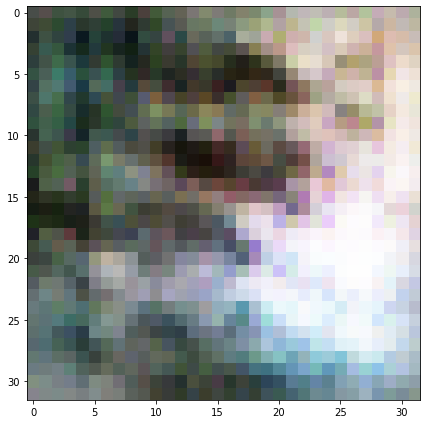

In [42]:
draw_training_checkpoints_image(1)


## Gan model 1

In [43]:
save_every = 5  # 모델 저장 간격
EPOCHS = 10  # 학습 횟수

In [44]:
# 체크 포인트 복구
checkpoint_dir = 'drive/MyDrive/Colab Notebooks/dcgan_newimage/cifar10/training_checkpints/training_checkpoints_1'
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

generator = checkpoint.generator
discriminator = checkpoint.discriminator

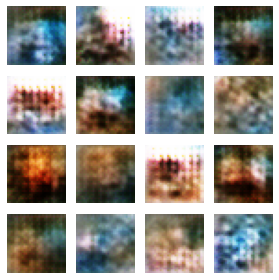

Time for training : 8524 sec


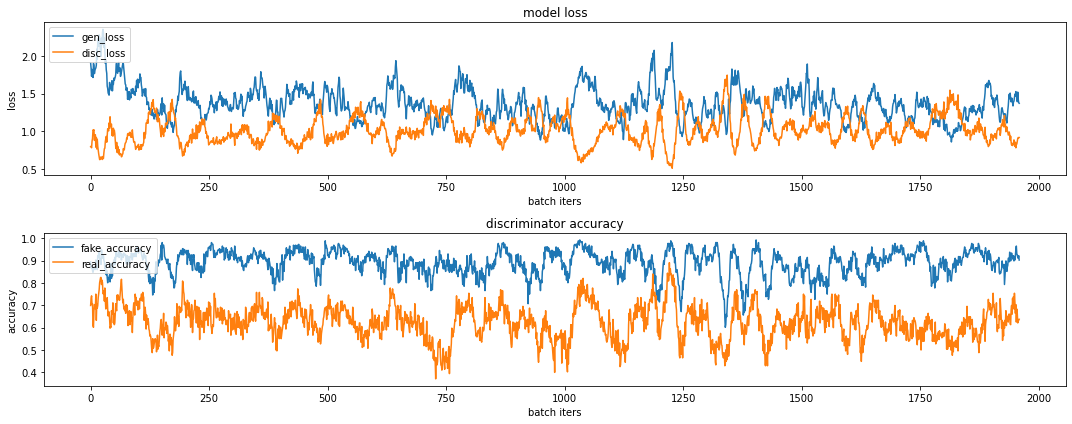

CPU times: user 4h 17min 18s, sys: 9min 1s, total: 4h 26min 20s
Wall time: 2h 22min 5s


In [45]:
%%time
train(train_dataset, EPOCHS, save_every, 2)

In [46]:
# Fake Images to GIF
make_a_gif(2, True)

FileNotFoundError: ignored

In [47]:
# History Graphs to GIF
make_a_gif(2, False)

FileNotFoundError: ignored

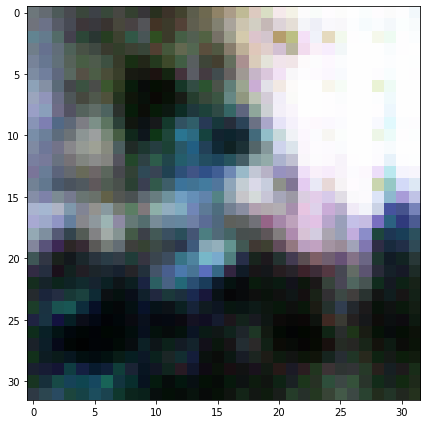

In [48]:
draw_training_checkpoints_image(2)

## Gan model 2

In [49]:
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()

train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

In [50]:
BUFFER_SIZE = 50000  # len(train_x) == 50000
BATCH_SIZE = 128  # 미니 배치 학습

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [51]:
# 생성자 생성 함수
def make_generator_model():

    g_kernel_size = 4
    g_LeakyReLU_alpha = 0.2

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer  # 32=8*4 이므로 8
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(512, kernel_size=(g_kernel_size, g_kernel_size), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(g_kernel_size, g_kernel_size), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(g_kernel_size, g_kernel_size), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(g_kernel_size, g_kernel_size), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Seventh: Conv2DTranspose layer  # output channel 설정
    model.add(layers.Conv2D(3, kernel_size=(g_kernel_size, g_kernel_size), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [52]:
generator = make_generator_model()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_3 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 512)        2097152   
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 512)       

In [53]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

In [54]:
def make_discriminator_model():

    d_kernel_size = 3
    d_LeakyReLU_alpha = 0.2
    d_dropout_rate = 0.5

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (d_kernel_size, d_kernel_size), strides=(1, 1), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=d_LeakyReLU_alpha))
    model.add(layers.Dropout(d_dropout_rate))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (d_kernel_size, d_kernel_size), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=d_LeakyReLU_alpha))
    model.add(layers.Dropout(d_dropout_rate))

    # Third: Conv2D Layer
    model.add(layers.Conv2D(128, (d_kernel_size, d_kernel_size), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=d_LeakyReLU_alpha))
    model.add(layers.Dropout(d_dropout_rate))

    # Fourth: Conv2D Layer
    model.add(layers.Conv2D(256, (d_kernel_size, d_kernel_size), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=d_LeakyReLU_alpha))
    model.add(layers.Dropout(d_dropout_rate))

    # FIfth: Flatten Layer
    model.add(layers.Flatten())

    # sixth: Dense Layer  # 숫자 1개(진짜라고 판단되는 정도)
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [55]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)        

In [56]:
decision = discriminator(generated_image, training=False)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [57]:
LR = 2e-4  # learning_rate
BETA_1=0.5

generator_optimizer = tf.keras.optimizers.Adam(LR, BETA_1, amsgrad=True)
discriminator_optimizer = tf.keras.optimizers.Adam(LR, BETA_1, amsgrad=True)

In [58]:
noise_dim = 100  # 100차원
num_examples_to_generate = 16  # 샘플 16개

seed = tf.random.normal([num_examples_to_generate, noise_dim])  # 고정된 seed 노이즈
seed.shape  # (16,100) 벡터

TensorShape([16, 100])

In [59]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [60]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [61]:
save_every = 5  # 모델 저장 간격
EPOCHS = 300  # 학습 횟수

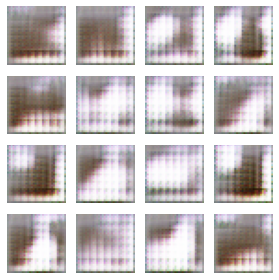

Epoch 2 | iter 201
Time for epoch 2 : 2908 sec


KeyboardInterrupt: ignored

In [62]:
train(train_dataset, EPOCHS, save_every, 3)


In [63]:
# Fake Images to GIF
make_a_gif(3, True)

FileNotFoundError: ignored

In [64]:
# History Graphs to GIF
make_a_gif(3, False)

FileNotFoundError: ignored

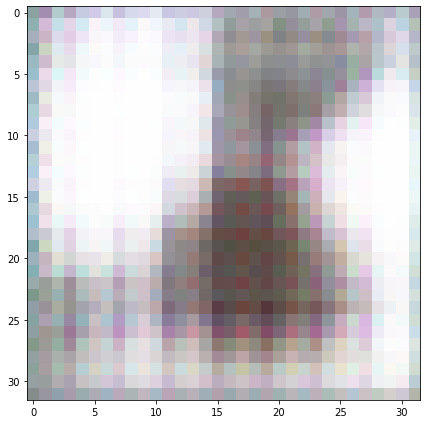

In [65]:
draw_training_checkpoints_image(3)

# 회고

먼저, 기존에 Epochs를 200과 100을 해봤는데 시간이 정말 많이 소요되었다. 코드를 다시 150과 300으로 늘려서 해보았는데 5시간이 지나도 완료되지 않아서 코드를 변경하였지만 첫 시도는 Epochs를 200과 100로 해보았다.

- 기본 해상도가 너무 낮아서 그런지 fake image 를 선명하게 생성하는 것이 쉽지 않았다.
- 모델의 레이어가 너무 깊어지면 이미지가 생성이 잘 안되는 것을 확인 할 수 있다.
- Epochs 를 200으로 해봤는데도 이미지에서 물체 형상만 보일 뿐 물체를 자세히 관찰할 수는 없었다.
- Epochs 를 늘렸을 때 훨씬 좋은 품질의 이미지가 형성된다. 하지만, 얼마나 더 높여야 고화질 이미지가 생성되는지 확인해봐야한다.